In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import cv2
import os
import tensorflow.image as tfi
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle
import tensorflow_hub as hub

In [2]:
label = ["nose", "left eye", "right eye", "left ear", "right ear", "left shoulder", "right shoulder", "left elbow", "right elbow", "left wrist", "right wrist", "left hip", "right hip", "left knee", "right knee", "left ankle", "right ankle"]
poses = ['standing', 'takedown', 'open_guard', 'half_guard', 'closed_guard', '5050_guard', 'side_control', 'mount', 'back', 'turtle']

In [3]:
# Download the model from TF Hub.
model = hub.load("../../movenet")
movenet = model.signatures['serving_default']

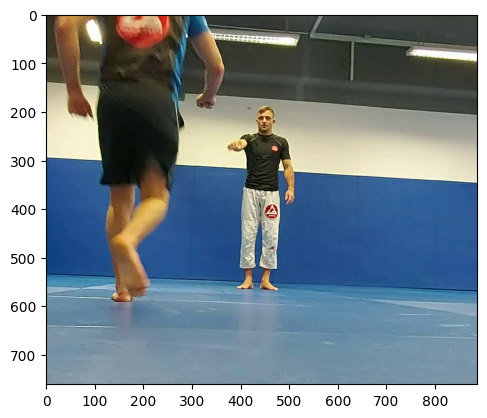

In [4]:
# Load the input image.
image_path = '../../test_images/standing.jpg'
image = tf.io.read_file(image_path)
image = tf.compat.v1.image.decode_jpeg(image)
# show the image
plt.imshow(image)
X = tf.expand_dims(image, axis=0)
X = tf.cast(tf.image.resize_with_pad(X, 640, 640), dtype=tf.int32)

In [5]:
outputs = movenet(X)
keypoints = outputs['output_0'].numpy()

In [6]:
keypoints.shape

(1, 6, 56)

In [7]:
max_key,key_val = keypoints[0,:,55].argmax(),keypoints[0,:,55].max()

# remove the max keypoint
temp_keypoints = np.delete(keypoints[0], max_key, axis=0)

# get the second max keypoint
second_max_key,second_key_val = temp_keypoints[:,55].argmax(),temp_keypoints[:,55].max()

In [8]:
max_points = keypoints[0,max_key,:]
max_points = max_points.astype(float)

second_max_points = temp_keypoints[second_max_key]
second_max_points = second_max_points.astype(float)


In [9]:
keypoints_reduced = []

# KEYPOINTS [Y,X,SCORE]

for i in range(0,len(max_points)-5,3):
    keypoints_reduced.extend([max_points[i+1],max_points[i], max_points[i+2]])
    
for i in range(0,len(second_max_points)-5,3):
    keypoints_reduced.extend([second_max_points[i+1],second_max_points[i], second_max_points[i+2]])
    
keypoints_reduced = np.array([keypoints_reduced])

# max_val = keypoints_reduced.max()

keypoints_reduced * 640

array([[323.39244843, 203.80069733, 410.10814667, 328.88942719,
        199.72650528, 420.59066772, 319.02999878, 199.1132164 ,
        487.09476471, 336.42799377, 204.7876358 , 479.65938568,
        313.75904083, 202.88600922, 488.47297668, 351.9562149 ,
        232.85215378, 552.46421814, 301.22659683, 226.26157761,
        523.26599121, 358.20178986, 271.07904434, 520.76553345,
        278.23225021, 242.74143219, 291.70345306, 363.35826874,
        304.3678093 , 500.02017975, 282.81682968, 240.56209564,
        350.85151672, 336.90700531, 303.38562012, 580.70903778,
        305.71872711, 301.51666641, 595.4058075 , 332.49340057,
        369.89589691, 511.83052063, 301.83761597, 368.26545715,
        558.86276245, 324.82162476, 438.78364563, 497.31033325,
        299.73768234, 435.59314728, 562.35683441, 134.60000992,
         68.04196358, 136.46018982, 150.41775703,  48.59318733,
        172.38233566, 126.54393196,  50.4981184 , 231.10256195,
        170.47010422,  49.1683197 , 156.

In [10]:
jiu_model = tf.keras.models.load_model("jiu_model.h5")

prediciton = jiu_model.predict(keypoints_reduced)

print(prediciton)

poses[np.argmax(prediciton)]

1/1 [==============================] - 0s 71ms/step
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


'side_control'

In [11]:
keypoints_dict = {}

for i in range(0, len(max_points)-5, 3):
    keypoints_dict[label[i//3]] = max_points[i:i+3] * 640

In [12]:
def make_pred(img, keypoints_dict, label):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img[0])
    plt.subplot(1, 3, 2)
    plt.imshow(img[0])
    plt.title('Pose')
    plt.axis('off')
    
    for i in range(17):
        plt.scatter(keypoints_dict[label[i]][1],keypoints_dict[label[i]][0],color='green')

    connections = [
        ('nose', 'left eye'), ('left eye', 'left ear'), ('nose', 'right eye'), ('right eye', 'right ear'),
        ('nose', 'left shoulder'), ('left shoulder', 'left elbow'), ('left elbow', 'left wrist'),
        ('nose', 'right shoulder'), ('right shoulder', 'right elbow'), ('right elbow', 'right wrist'),
        ('left shoulder', 'left hip'), ('right shoulder', 'right hip'), ('left hip', 'right hip'),
        ('left hip', 'left knee'), ('right hip', 'right knee'), ('left knee', 'left ankle'), ('right knee', 'right ankle')
    ]

    for start_key, end_key in connections:
        if start_key in keypoints_dict and end_key in keypoints_dict:
            start_point = keypoints_dict[start_key][:2]  # Take first two values
            end_point = keypoints_dict[end_key][:2]      # Take first two values
            plt.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]], linewidth=2)
    
    plt.subplot(1, 3, 3)
    plt.imshow((img[0]/255)/255)
    plt.title('Only Pose Image')
    for start_key, end_key in connections:
        if start_key in keypoints_dict and end_key in keypoints_dict:
            start_point = keypoints_dict[start_key][:2]  # Take first two values
            end_point = keypoints_dict[end_key][:2]      # Take first two values
            plt.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]], linewidth=2)

In [13]:
img = tf.image.resize_with_pad(image, 640, 640)
img = tf.cast(img, dtype=tf.int32)
img = tf.expand_dims(img, axis=0)
img = img.numpy()

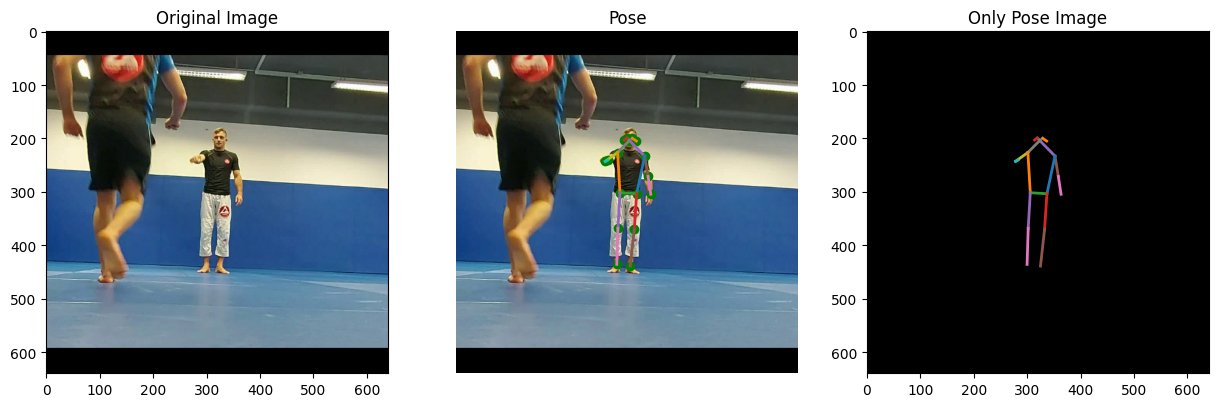

In [14]:
make_pred(img, keypoints_dict, label)